## conv2d analysis

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns;
import scipy
import os

from data_utils import *
from plot_utils import *

matplotlib.rcParams['figure.dpi']= 200

colors = sns.color_palette("hls", n_colors=11)

In [8]:
d_ascend910_conv2d = get_data('ascend910_conv2d')
ascend910_peak_flops = 256e12

print(f"ascend910 total data points:  {len(d_ascend910_conv2d['labels'])}")
d_ascend910_conv2d_flops = np.array(d_ascend910_conv2d['flops'])
indices = np.where(d_ascend910_conv2d_flops > 0.0)
d_ascend910_conv2d_flops = d_ascend910_conv2d_flops[indices]
print(f"ascend910 flops that > 0: {d_ascend910_conv2d_flops.size}")

ascend910 total data points:  288
ascend910 flops that > 0: 76


In [9]:
d_v100_conv2d = get_data('v100_conv2d')
v100_peak_flops = 125e12

print(f"v100 total data points:  {len(d_v100_conv2d['labels'])}")
d_v100_conv2d_flops = np.array(d_v100_conv2d['flops'])
indices = np.where(d_v100_conv2d_flops > 0.0)
d_v100_conv2d_flops = d_v100_conv2d_flops[indices]
print(f"v100 flops that > 0: {d_v100_conv2d_flops.size}")

v100 total data points:  288
v100 flops that > 0: 144


### max flops

In [10]:
max_index = np.argmax(d_ascend910_conv2d['flops'])
max_flops = d_ascend910_conv2d['flops'][max_index]
print(f"max flops {max_flops} FLOPS%: {max_flops/ascend910_peak_flops}")
print(f"max flops with label {d_ascend910_conv2d['labels'][max_index]}")

max flops 225000045284873.34 FLOPS%: 0.8789064268940365
max flops with label bs_512-input_224-inchannel_32-outchannel_128-filtersize_7


In [12]:
min_index = 0
min_flops = 256e12
for i in range(len(d_ascend910_conv2d['labels'])):
    if d_ascend910_conv2d['state'][i] == "fine" and d_ascend910_conv2d['flops'][i] < min_flops:
        min_index = i
        min_flops = d_ascend910_conv2d['flops'][i]
print(f"min flops {min_flops} FLOPS%: {min_flops/ascend910_peak_flops}")
print(f"min flops with label {d_ascend910_conv2d['labels'][min_index]}")

min flops 12602014589047.752 FLOPS%: 0.04922661948846778
min flops with label bs_128-input_448-inchannel_32-outchannel_64-filtersize_1


### LR weights

['bs', '1024']
['input', '448']
['inchannel', '128']
['outchannel', '128']
['filtersize', '5']
check x y [ 1.58525817  1.          1.33630621 -0.26726124  0.4472136 ] -0.5051514311783809


/home/u20200002/.conda/envs/torch1.5/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


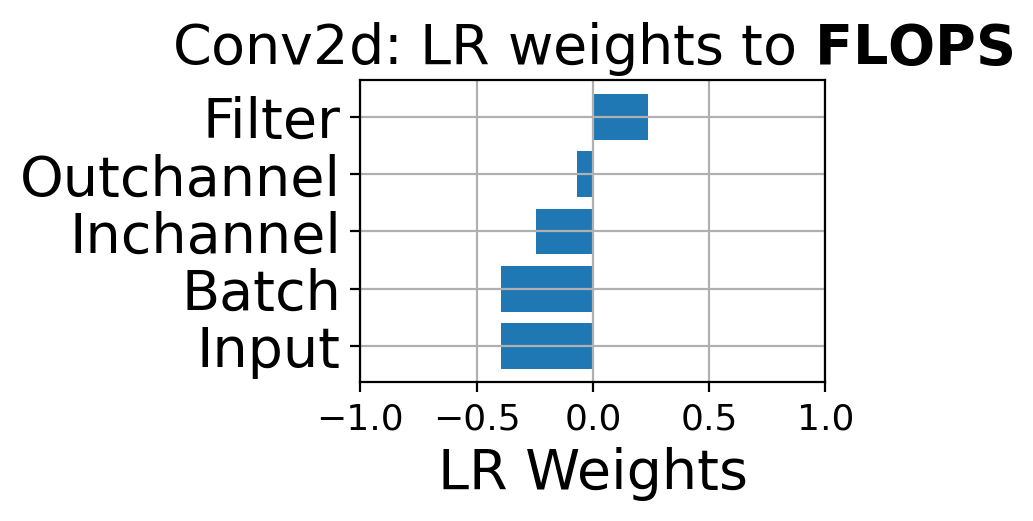

In [13]:
from ml_utils import *
f = regression(d_ascend910_conv2d['labels'], d_ascend910_conv2d['flops'],
               title = r'Conv2d: LR weights to $\bf{FLOPS}$')

['bs', '512']
['input', '448']
['inchannel', '128']
['outchannel', '64']
['filtersize', '1']
check x y [ 0.09325048  1.          1.33630621 -1.06904497 -1.34164079] -0.775538957922498


/home/u20200002/.conda/envs/torch1.5/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


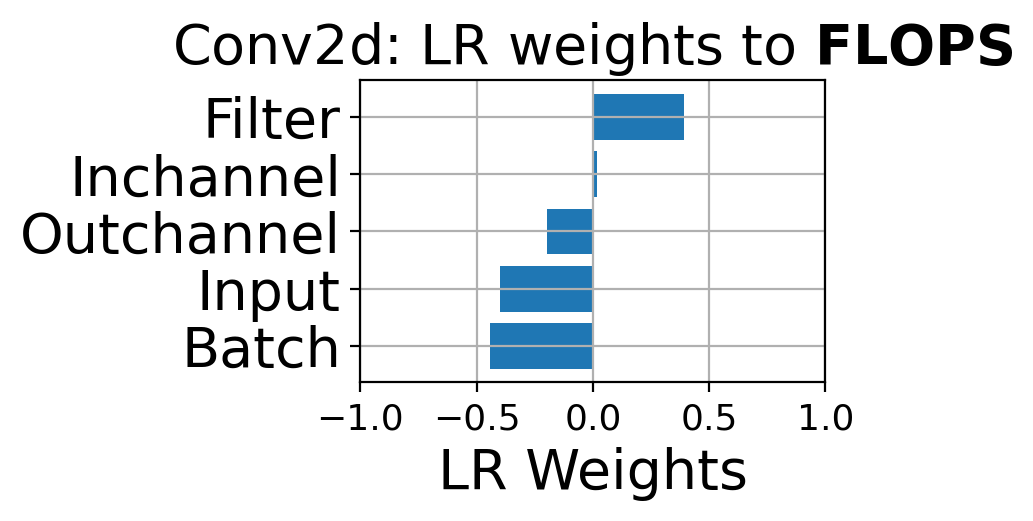

In [14]:
f = regression(d_v100_conv2d['labels'], d_v100_conv2d['flops'],
               title = r'Conv2d: LR weights to $\bf{FLOPS}$')

## Speedup

length of speedups 76
max speedup: 7.270015250479452 label: bs_128-input_224-inchannel_64-outchannel_128-filtersize_5
min speedup: 1.2509137657576572 label: bs_128-input_224-inchannel_128-outchannel_256-filtersize_7
bs [128, 256, 512]
input [224, 448]
inchannel [32, 64, 128]
outchannel [64, 128, 256]
filtersize [1, 3, 5, 7]
-----------------------


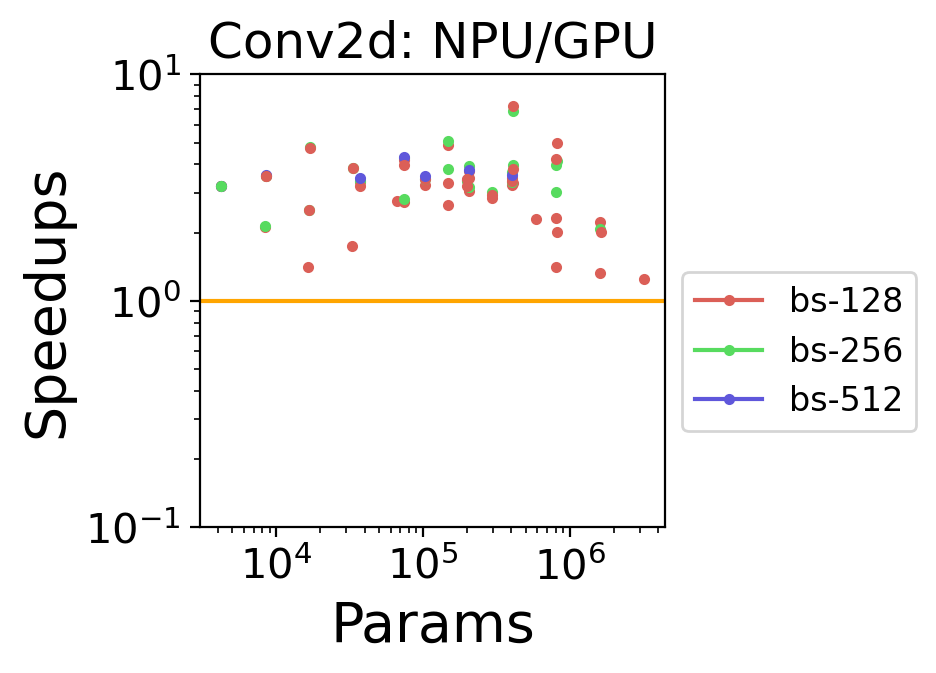

In [17]:
from plot_utils import *
f = speedup_params(d_ascend910_conv2d['labels'], d_ascend910_conv2d['example_per_sec'], 
               d_v100_conv2d['labels'], d_v100_conv2d['example_per_sec'], d_v100_conv2d['params'],  marker='.', lim=[0.1, 10],
                   legend_box=(1,0.6),
               color='bs', title= 'Conv2d: NPU/GPU')

## Error Reason

In [94]:
states = np.array(d_ascend910_conv2d['state'])
labels = np.array(d_ascend910_conv2d['labels'])

103

In [99]:
is_error = np.where(states == 'error', 2, 0)

['bs', '128']
['input', '224']
['inchannels', '32']
['outchannels', '128']
['filtersize', '7']
0.7193460490463215


ValueError: too many values to unpack (expected 2)

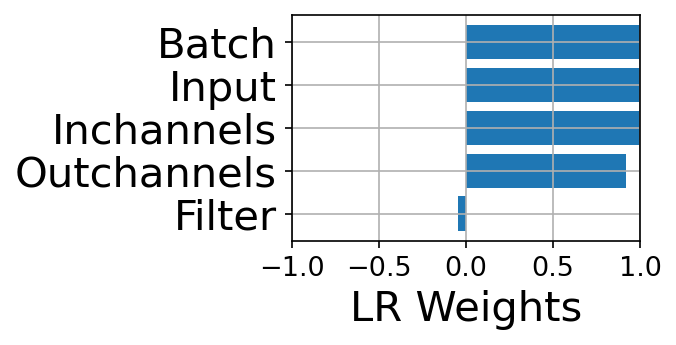

In [100]:
error_cls = classification(labels, is_error)

## Roofline

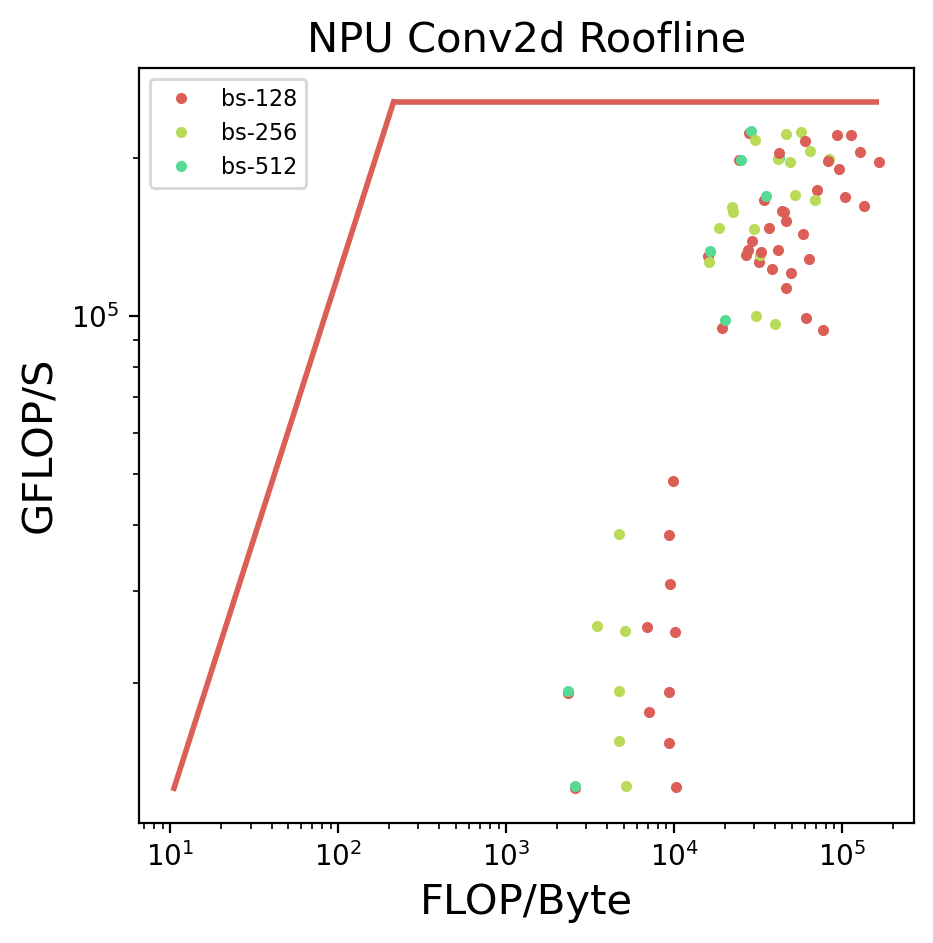

In [18]:
color_dim = 'bs'

f, ax = plt.subplots(figsize=(5,5))
f, ax, m = plot_roofline(f, ax, d_ascend910_conv2d, flops_peak=256e3, membdw_peak=1200, color_dim=color_dim, marker='o', title='NPU Conv2d Roofline')

# sort the legend

handles, ls = ax.get_legend_handles_labels()
ls = [int(i) for i in ls if i.isdigit()] 
ls, handles = zip(*sorted(zip(ls, handles), key=lambda t: t[0]))
ls = [color_dim + '-' + str(i) for i in ls]
ax.legend(handles, ls, frameon=True, fontsize=8)